In [1]:
import numpy as np
from scipy import sparse
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt, colors, cm

from tqdm import tqdm

from gcv.sketches import CountSketchFactory, SubsampledFourierSketchFactory
from gcv.sketches import SketchSizeParams


In [23]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}\usepackage{mathrsfs}')
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'v', 'D', 'P', 'X', '*']

In [3]:
n_polys = 2
L = 4
polys = np.array([
    [1, 2, 2, 3],
    [3, 1, 4, 2],
])

In [4]:
def compute_power_traces(A, B=None, upto=1):

    p = A.shape[0]
    traces = [1]

    if B is None:
        assert A.shape[1] == p
        B = sparse.eye(p, dtype=A.dtype)
    
    C = np.eye(p, dtype=A.dtype)
    for i in range(upto):
        C = A @ (B @ C)
        traces.append(np.trace(C) / p)
    
    return traces


In [6]:
rng = np.random.default_rng(0)
p0 = 50
q0 = 30
n_trials = 10
# scale_factors = np.logspace(1, np.log10(50.1), 5).astype(int)
scale_factors = np.unique(np.logspace(1, np.log10(60 + 1e-3), 30).astype(int))
sketches = ['CountSketch', 'SRDCT']

traces_poly = np.zeros((len(sketches), len(scale_factors), n_polys, n_trials))
max_k = np.max(polys)

for r, sketch in enumerate(sketches):
    for t, scale in enumerate(scale_factors):

        p = p0 * scale
        q = q0 * scale

        if sketch == 'CountSketch':
            sf = CountSketchFactory(p, rng=rng)
        elif sketch == 'SRDCT':
            sf = SubsampledFourierSketchFactory(p, transform='dct', rng=rng)

        a = np.linspace(0, 1, p) + 0.5
        A = sparse.spdiags(a, 0, p, p, format='csr')

        for i in tqdm(range(n_polys), desc=f"sketch={sketch}, scale={scale}"):

            for u in range(n_trials):

                Sh = sf(SketchSizeParams(q))
                traces_S = compute_power_traces(Sh.T, Sh, upto=max_k + 1)
                traces_A = compute_power_traces(A, upto=max_k + 1)

                C = np.eye(p)

                for j, k in enumerate(polys[i, :]):

                    Ck = C.copy()
                    
                    if j % 2 == 0:
                        for _ in range(k):
                            Ck = A @ Ck
                        C = Ck - traces_A[k] * C
                    else:
                        for _ in range(k):
                            Ck = Sh.T @ (Sh @ Ck)
                        C = Ck - traces_S[k] * C
                
                traces_poly[r, t, i, u] = np.trace(C) / p
                

sketch=CountSketch, scale=10:   0%|          | 0/2 [00:00<?, ?it/s]

sketch=SRDCT, scale=60: 100%|██████████| 2/2 [00:26<00:00, 13.35s/it]


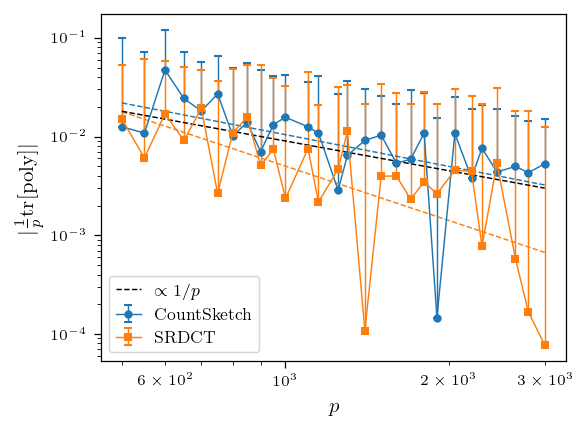

In [11]:
traces_poly_collapse = traces_poly.reshape((len(sketches), len(scale_factors), -1))

for r, sketch in enumerate(sketches):
    plt.errorbar(scale_factors * p0, np.abs(np.mean(traces_poly_collapse[r, :, :], axis=1)), yerr=np.vstack((np.zeros(len(scale_factors)), np.std(traces_poly_collapse[r, :, :], axis=1))), label=sketch, marker=marker_cycle[r], color=color_cycle[r], capsize=2)

# plot best fit lines on log log scale
for r, sketch in enumerate(sketches):
    popt = np.polyfit(np.log(scale_factors * p0), np.log(np.abs(np.mean(traces_poly_collapse[r, :, :], axis=1))), deg=1)
    plt.plot(scale_factors * p0, np.exp(popt[1]) * (scale_factors * p0) ** popt[0], color=color_cycle[r], linestyle='--')

plt.plot(scale_factors * p0, 9 / (scale_factors * p0), color='k', linestyle='--', label=r'$\propto 1/p$')

plt.xlabel('$p$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.ylabel(r'$|\tfrac{1}{p} \mathrm{tr}[\mathrm{poly}]|$')
plt.show()

In [12]:
rng = np.random.default_rng(0)
p = 500
q = 372
p = 700
q = 585
sf = CountSketchFactory(p, rng=rng)
Sh = sf(SketchSizeParams(q))
q = Sh.shape[0]
print(Sh.shape)

def generate_sigmoid_a(n, offset=0.5, scale=1.0, amplitude=1.0):
    ts = np.linspace(0, 1, n)
    return amplitude * (1 / (1 + np.exp(-scale * (ts - offset))))

def estimate_mu(trace_sketch, a):
    
    def f(mu):
        return np.sum(a / (a + mu)) - trace_sketch
    
    return root_scalar(f, bracket=[1e-8, (len(a) / trace_sketch - 1) * np.max(a)]).root

def sketch_diags(Sh, a, lamda):
    Sh_dense = Sh.todense()
    SAS = Sh @ (a[:, None] * Sh_dense.T)
    return Sh.T @ np.linalg.solve(SAS + lamda * np.eye(Sh.shape[0]), Sh_dense)

offsets = np.linspace(0, 1, 5)
scales = np.linspace(0.1, 10, 5)
amplitudes = np.linspace(0.1, 10, 5)
lamdas = np.logspace(-2, 2, 5)

# compute fs for a given lamda
def us_mus_given_lamda(lamda, Sh, offsets, scales, amplitudes):
    us = np.zeros((len(offsets), len(scales), len(amplitudes)))
    mus = np.zeros((len(offsets), len(scales), len(amplitudes)))
    for i, offset in enumerate(offsets):
        for j, scale in enumerate(scales):
            for k, amplitude in enumerate(amplitudes):
                a = generate_sigmoid_a(p, offset, scale, amplitude)
                diags = sketch_diags(Sh, a, lamda)
                mus[i, j, k] = estimate_mu(np.sum(diags * a), a)
                us[i, j, k] = - np.mean(a / (a + mus[i, j, k]))
    return us, mus

us = np.zeros((len(sketches), len(lamdas), len(offsets), len(scales), len(amplitudes)))
mus = np.zeros((len(sketches), len(lamdas), len(offsets), len(scales), len(amplitudes)))
errors = np.zeros((len(sketches), len(lamdas), len(offsets), len(scales), len(amplitudes)))

for r, sketch in enumerate(sketches):
    
    if sketch == 'CountSketch':
        sf = CountSketchFactory(p, rng=rng)
    elif sketch == 'SRDCT':
        sf = SubsampledFourierSketchFactory(p, transform='dct', perm=False, rng=rng)
    Sh = sf(SketchSizeParams(q))

    for i, lamda in enumerate(tqdm(lamdas)):
        us[r, i, :, :, :], mus[r, i, :, :, :] = us_mus_given_lamda(lamda, Sh, offsets, scales, amplitudes)

(585, 700)


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


In [13]:
offsets, scales, amplitudes, lamdas

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([ 0.1  ,  2.575,  5.05 ,  7.525, 10.   ]),
 array([ 0.1  ,  2.575,  5.05 ,  7.525, 10.   ]),
 array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]))

In [16]:
np.min(us), np.max(us), q / p

(-0.8479986044871944, -6.195069964530103e-05, 0.8357142857142857)

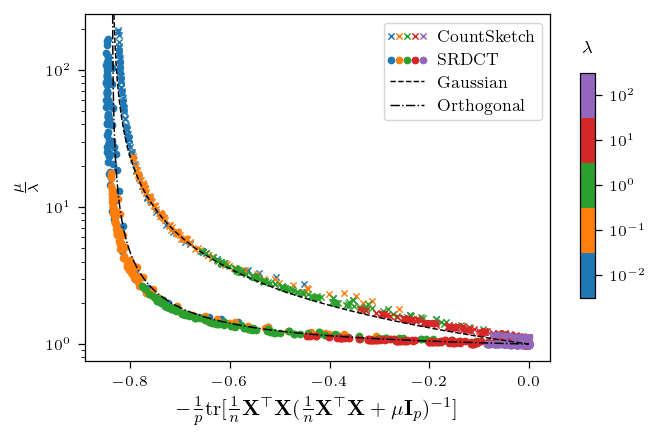

In [21]:
markers = ['x', 'o']

scatters = []

for r, sketch in enumerate(sketches):
    scatters.append([])
    for i, lamda in enumerate(lamdas):
        scatter = plt.scatter(us[r, i, :, :, :].ravel(), mus[r, i, :, :, :].ravel() / lamda, marker=markers[r], color=color_cycle[i], label=sketch) #, alpha=0.5)
        scatters[r].append(scatter)

plt.yscale('log')
plt.xlabel(r'$-\tfrac{1}{p} \mathrm{tr}[\tfrac{1}{n} \mathbf{X}^\top \mathbf{X} (\tfrac{1}{n} \mathbf{X}^\top \mathbf{X} + \mu \mathbf{I}_p)^{-1}]$')
plt.ylabel(r'$\frac{\mu}{\lambda}$')

ylim = plt.ylim()
us_lin = np.linspace(-q / p + 1e-4, np.max(us), 1000)
gauss_line, = plt.plot(us_lin, q / p / (q / p + us_lin), color='k', linestyle='--', label='Gaussian')
ortho_line, = plt.plot(us_lin, q / p * (1 + us_lin) / (q / p + us_lin), color='k', linestyle='-.', label='Orthogonal')
plt.ylim(ylim)

from matplotlib.legend_handler import HandlerTuple
plt.legend(
    [tuple(scatters[0]), tuple(scatters[1]), gauss_line, ortho_line],
    sketches + ['Gaussian', 'Orthogonal'],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    numpoints=1, handlelength=2,
    loc='upper right'
)

# custom colorbar mapping colors of tab10 to lamdas
fig = plt.gcf()
ax = fig.add_axes([0.95, 0.25, 0.025, 0.5])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 1), cmap='tab10'), cax=ax)
ax.set_ylim(0, len(lamdas) / 10)
ax.set_yticks((np.arange(len(lamdas)) + 0.5) / 10, [r'$10^{%d}$' % round(np.log10(lamda)) for lamda in lamdas])
ax.set_title(r'$\lambda$', pad=10)

plt.show()

/var/folders/11/6tvn8zsd7ps02dw3jvvkg5840000gr/T/ipykernel_11848/2565339712.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


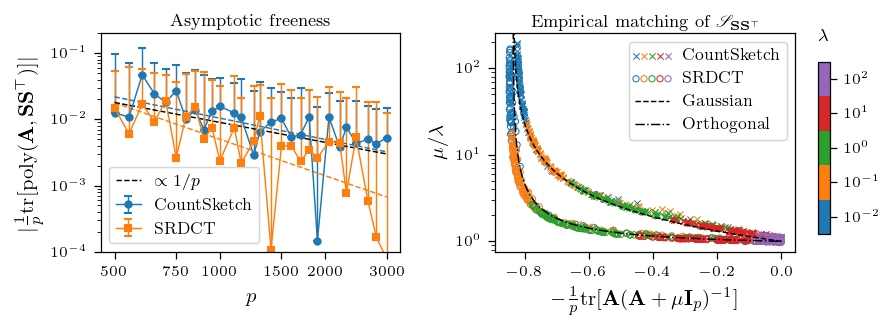

In [30]:
# plot both previous plots together
p = 700
q = 585

fig, axes = plt.subplots(1, 2, figsize=(5.5, 2.3))

for r, sketch in enumerate(sketches):
    axes[0].errorbar(scale_factors * p0, np.abs(np.mean(traces_poly_collapse[r, :, :], axis=1)), yerr=np.vstack((np.zeros(len(scale_factors)), np.std(traces_poly_collapse[r, :, :], axis=1))), label=sketch, marker=marker_cycle[r], color=color_cycle[r], capsize=2)

# plot best fit lines on log log scale
for r, sketch in enumerate(sketches):
    popt = np.polyfit(np.log(scale_factors * p0), np.log(np.abs(np.mean(traces_poly_collapse[r, :, :], axis=1))), deg=1)
    axes[0].plot(scale_factors * p0, np.exp(popt[1]) * (scale_factors * p0) ** popt[0], color=color_cycle[r], linestyle='--')

axes[0].plot(scale_factors * p0, 9 / (scale_factors * p0), color='k', linestyle='--', label=r'$\propto 1/p$')

axes[0].set_title('Asymptotic freeness')
axes[0].set_xlabel('$p$')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(1e-4, 2e-1)
axes[0].set_ylabel(r'$|\tfrac{1}{p} \mathrm{tr}[\mathrm{poly}(\mathbf{A},\mathbf{S} \mathbf{S}^\top)]|$')
axes[0].legend()

xticks = [500, 750, 1000, 1500, 2000, 3000]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([r'$%d$' % x for x in xticks])
axes[0].set_xticks([], minor=True)

scatters = []
for r, sketch in enumerate(sketches):
    scatters.append([])
    for i, lamda in enumerate(lamdas):
        if r == 1:
            facecolors = 'none'
        else:
            facecolors = color_cycle[i]
        scatter = axes[1].scatter(us[r, i, :, :, :].ravel(), mus[r, i, :, :, :].ravel() / lamda, marker=markers[r], color=color_cycle[i], label=sketch, linewidths=0.5, facecolors=facecolors)
        scatters[r].append(scatter)

axes[1].set_title(r'Empirical matching of $\mathscr{S}_{\mathbf{S} \mathbf{S}^\top}$')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$- \tfrac{1}{p} \mathrm{tr}[\mathbf{A} (\mathbf{A} + \mu \mathbf{I}_p)^{-1}]$')
axes[1].set_ylabel(r'$\mu/\lambda$')

ylim = axes[1].get_ylim()
us_lin = np.linspace(- q / p + 1e-4, np.max(us), 1000)
gauss_line, = axes[1].plot(us_lin, q / p / (q / p + us_lin), color='k', linestyle='--', label='Gaussian')
ortho_line, = axes[1].plot(us_lin, q / p * (1 + us_lin) / (q / p + us_lin), color='k', linestyle='-.', label='Orthogonal')
axes[1].set_ylim(ylim)

from matplotlib.legend_handler import HandlerTuple
axes[1].legend(
    [tuple(scatters[0]), tuple(scatters[1]), gauss_line, ortho_line],
    sketches + ['Gaussian', 'Orthogonal'],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    numpoints=1, handlelength=2,
    loc='upper right'
)

# custom colorbar mapping colors of tab10 to lamdas
fig = plt.gcf()
ax = fig.add_axes([1.0, 0.3, 0.015, 0.5])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 1), cmap='tab10'), cax=ax)
ax.set_ylim(0, len(lamdas) / 10)
ax.set_yticks((np.arange(len(lamdas)) + 0.5) / 10, [r'$10^{%d}$' % round(np.log10(lamda)) for lamda in lamdas])
ax.set_title(r'$\lambda$', pad=10)

plt.tight_layout()
plt.savefig('figures/free_sketching_investigation.pdf', bbox_inches='tight')
plt.show()